# **Background And Motivation**

A stroke occurs when the blood supply to the brain is interrupted, which will casue Brain cells dying in a short period of time. A stroke is a medical emergency which caused a lot of people passing away unexpectedly. However, the stoke patients always shared similiar chracteristics. Moreover, early action can reduce brain damage and prevent diability and death.

Motivation : Our objective is to choose the right machine learning model based on stroke patients' data to succefully detect stroke for early action

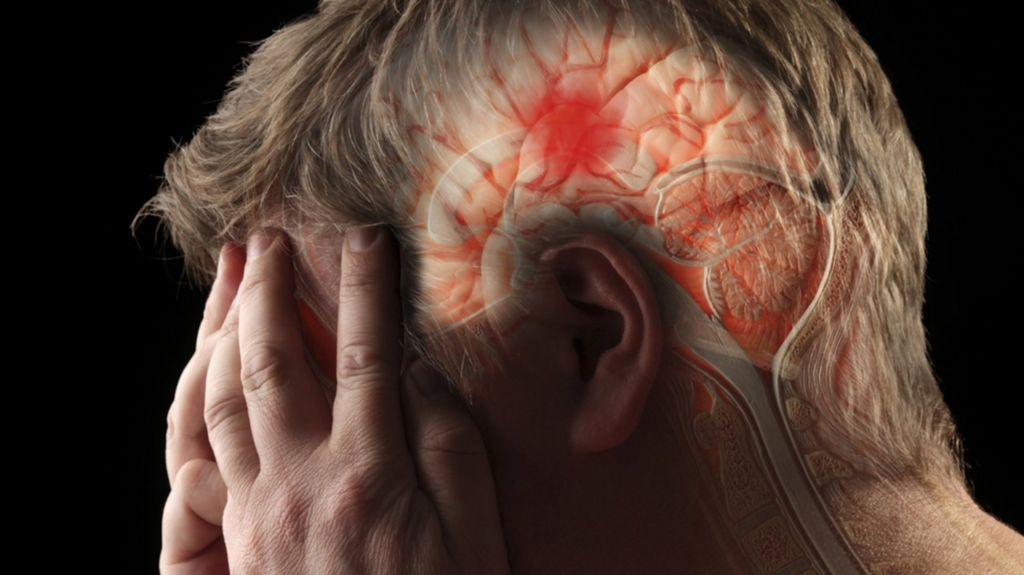

# **Importing libraries**

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV

In [65]:
import numpy
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier, KerasRegressor

# **Importing dataset & first look of the dataset**

In [31]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

### First look on the data

In [32]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [34]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [35]:
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.823064
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.471292


### Exploratory data analysis

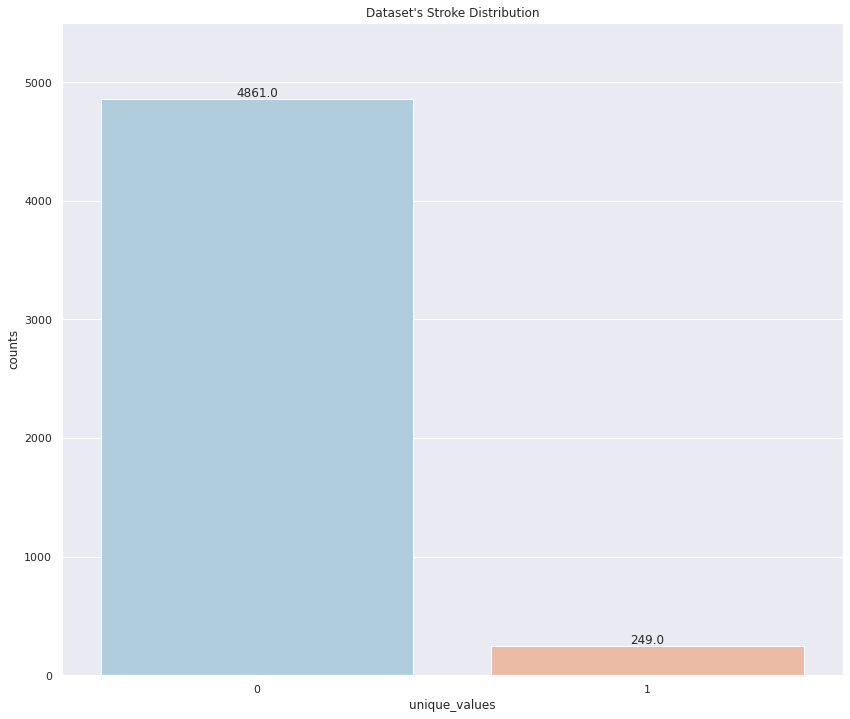

In [36]:
sns.set_style('white')
sns.set(rc = {'figure.figsize':(14,12)})
sns.set_palette("RdBu_r",2)
df_counts = df['stroke'].value_counts().rename_axis('unique_values').to_frame('counts').reset_index()
g1=sns.barplot(x='unique_values', y= 'counts', data= df_counts)
g1.set_title("Dataset's Stroke Distribution")
g1.set(ylim=(0,5500))
for p in g1.patches:
    g1.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0,5), 
                   textcoords = 'offset points')
plt.show()

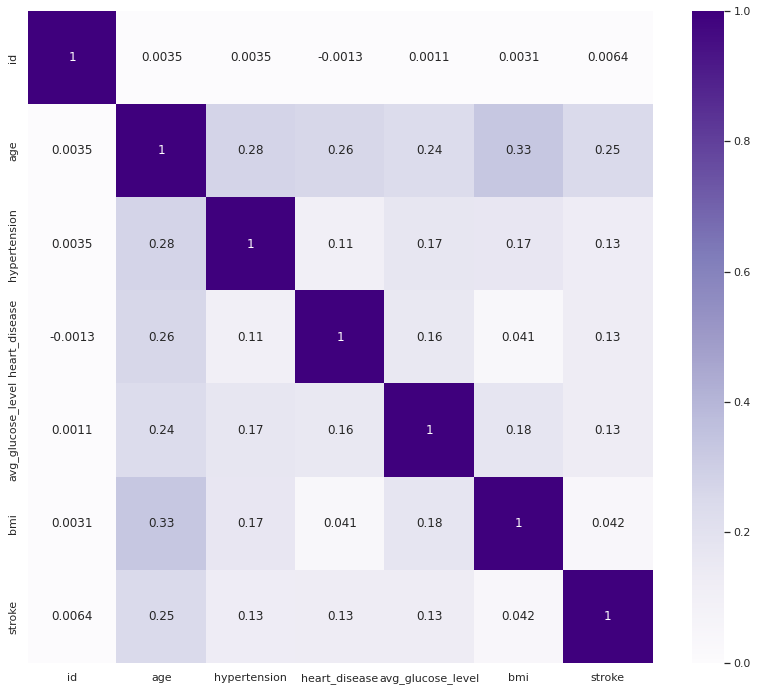

In [37]:
sns.heatmap(df.corr(), cmap = 'Purples',annot=True)
plt.show()

# **Data cleaning**

## Step 1:

#### First, We want to find the **null** values in our dataset. We found only bmi column has 201 NA values. So we filled them with mean bmi of dataset.

In [38]:
df.isna().sum() 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [39]:
df['bmi'] = df['bmi'].fillna(np.round(df.bmi.mean(), 2))
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

##### We also filled the unknown "smoking_status" with the mode status of the dataset.

In [40]:
df['smoking_status'].replace('Unknown', df['smoking_status'].mode()[0], inplace=True)
df['smoking_status'].head()

0    formerly smoked
1       never smoked
2       never smoked
3             smokes
4       never smoked
Name: smoking_status, dtype: object

##### We also dropped id column from dataset because it is useless infomation

In [41]:
df.drop('id', axis=1, inplace=True)
df = df[df['gender'] != 'Other']
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


## STEP 2:

#### Next Step, we located **categorical** data and **numeric_data** seperately and store them in different dataframe and used StandardScaler from Sklearn package to standardize numeric data and LabelEncoder to transform the categorical data.

In [42]:
numeric_data=df.loc[:,df.nunique() > 5]
cols = [col for col in df.columns if col not in numeric_data]
categorical_data=df[cols].drop('stroke',axis=1)
numeric_data=pd.DataFrame(numeric_data)
categorical_data=pd.DataFrame(categorical_data)
print(f'Numerical data: {list(numeric_data)}')
print(f'Categorical data: {list(categorical_data)}')

Numerical data: ['age', 'avg_glucose_level', 'bmi']
Categorical data: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [43]:
# Arrange the data in a standard normal distribution
num_cols=numeric_data.columns.to_list()
sc = StandardScaler()
df[num_cols] = sc.fit_transform(df[num_cols])
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.051242,0,1,Yes,Private,Urban,2.706450,1.001057,formerly smoked,1
1,Female,0.785889,0,0,Yes,Self-employed,Rural,2.121652,-0.000569,never smoked,1
2,Male,1.626174,0,1,Yes,Private,Rural,-0.004867,0.468415,never smoked,1
3,Female,0.255182,0,0,Yes,Private,Urban,1.437473,0.715249,smokes,1
4,Female,1.581949,1,0,Yes,Self-employed,Rural,1.501297,-0.635842,never smoked,1


In [44]:
# Convert the labels into a numeric form
cat_cols=categorical_data.columns.to_list()
le = LabelEncoder()
for col in cat_cols:
  df[col]= le.fit_transform(df[col])
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.051242,0,1,1,2,1,2.706450,1.001057,0,1
1,0,0.785889,0,0,1,3,0,2.121652,-0.000569,1,1
2,1,1.626174,0,1,1,2,0,-0.004867,0.468415,1,1
3,0,0.255182,0,0,1,2,1,1.437473,0.715249,2,1
4,0,1.581949,1,0,1,3,0,1.501297,-0.635842,1,1


## STEP 3:

Then spliting the data into training set and test set (validation set)

In [45]:
x= df.iloc[:,0:-1] # X varibles
y= df['stroke'] # y varibles
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

## STEP 4:

#### From the scatter plot below, we find that we have a very **Imbalanced** , Classification. We further needed use SMOTE() to solve the issue.

In [46]:
df_train = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

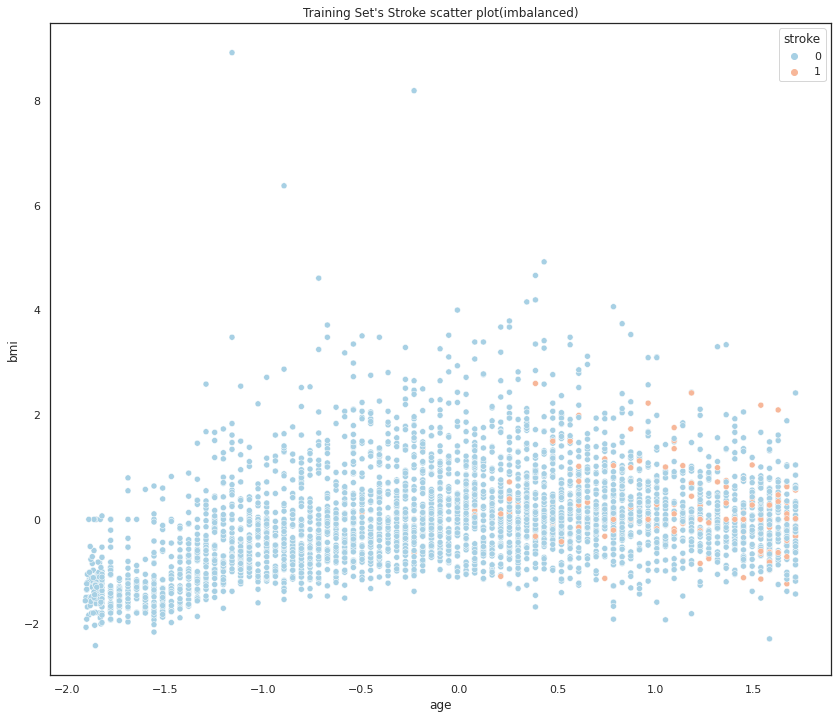

In [47]:
# Visualize the Data
sns.set_style('white')
g2 = sns.scatterplot(x= 'age', y='bmi',data=df_train, marker='o', hue = 'stroke')
g2.set_title("Training Set's Stroke scatter plot(imbalanced)")
plt.show()

In [48]:
os = SMOTE(random_state=0)
columns = x_train.columns
os_data_x,os_data_y=os.fit_resample(x_train, y_train)
os_data_x = pd.DataFrame(data=os_data_x,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['stroke'])

print("length of oversampled data is ",len(os_data_x))
print("Number of no stroke in oversampled data",len(os_data_x[os_data_y['stroke']==0]))
print("Number of having stroke",len(os_data_y[os_data_y['stroke']==1]))
print("Proportion of no stroke data in oversampled data is ",len(os_data_y[os_data_y['stroke']==0])/len(os_data_x))
print("Proportion of having stroke data in oversampled data is ",len(os_data_y[os_data_y['stroke']==1])/len(os_data_x))

length of oversampled data is  6832
Number of no stroke in oversampled data 3416
Number of having stroke 3416
Proportion of no stroke data in oversampled data is  0.5
Proportion of having stroke data in oversampled data is  0.5


In [49]:
os_data= pd.concat([os_data_x,os_data_y], axis =1)

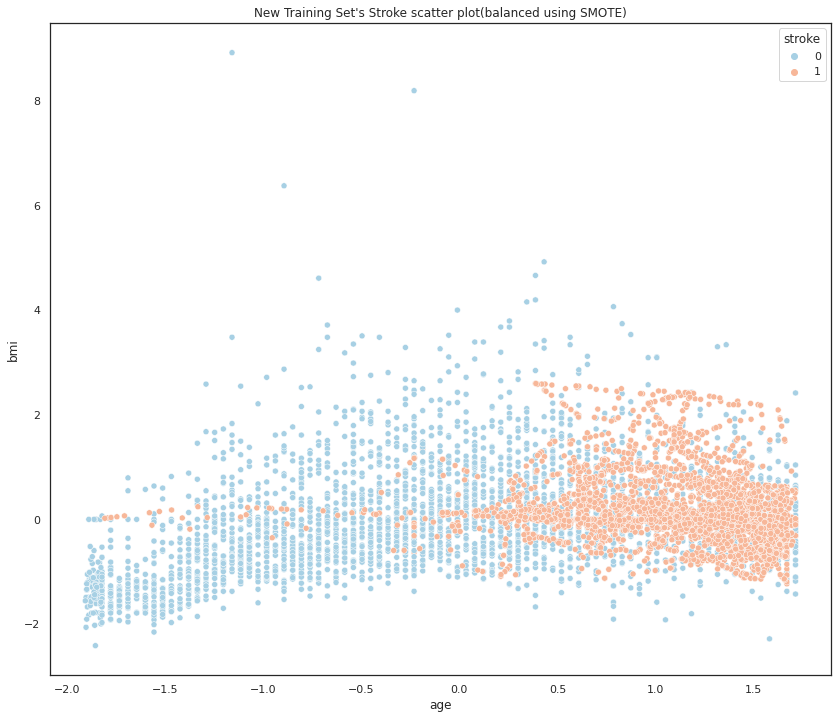

In [50]:
g3=sns.scatterplot(x= 'age', y='bmi',data=os_data, marker='o', hue = 'stroke')
g3.set_title("New Training Set's Stroke scatter plot(balanced using SMOTE)")
plt.show()

#### We can see after using SMOTE(), we have a **balanced** training set.

## One-Hot Encoding for Neural Network Model

Since in Neural Network model, in order to perform categorical crossentropy for two classes, we need to further don one-hot encoding to work-type column.

In [51]:
from sklearn.preprocessing import OneHotEncoder

onehot_work_type = OneHotEncoder(categories = [[0,1,2,3,4]])

os_data_x_worktype = pd.DataFrame(onehot_work_type.fit_transform(os_data_x[['work_type']]).toarray())
os_data_x_worktype.columns = onehot_work_type.get_feature_names_out(['work_type'])

x_test_worktype = pd.DataFrame(onehot_work_type.fit_transform(x_test[['work_type']]).toarray())
x_test_worktype.columns = onehot_work_type.get_feature_names_out(['work_type'])
os_data_drop = os_data_x.drop('work_type', axis=1)
os_data_onehot = pd.concat([os_data_drop, os_data_x_worktype], axis=1)
x_test_drop = x_test.drop('work_type', axis=1).reset_index()
x_test_onehot = pd.concat([x_test_drop, x_test_worktype], axis=1).reset_index().drop(['level_0','index'], axis = 1)
display(os_data_onehot)
display(x_test_onehot)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4
0,1,-1.248487,0,0,0,0,-0.691475,-1.493265,1,0.0,0.0,0.0,0.0,1.0
1,1,-0.629329,0,0,0,1,2.240246,-0.791737,2,0.0,0.0,1.0,0.0,0.0
2,1,0.034054,1,0,1,0,-0.328185,-0.311060,1,0.0,0.0,1.0,0.0,0.0
3,0,1.095468,1,0,1,1,0.984961,1.481734,1,0.0,0.0,1.0,0.0,0.0
4,0,0.830114,0,0,1,0,-0.520541,0.923110,0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,0,0.302559,0,0,1,1,1.367444,0.331833,1,0.0,0.0,1.0,0.0,0.0
6828,0,1.300812,0,0,1,1,2.127742,0.476157,0,0.0,0.0,0.0,1.0,0.0
6829,1,1.622345,0,0,1,1,-0.735572,-0.236214,1,0.0,0.0,1.0,0.0,0.0
6830,0,1.218836,0,0,1,0,-0.289624,-0.547638,1,0.0,0.0,1.0,0.0,0.0


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4
0,1,-0.540878,0,0,0,0,-0.911879,-0.765754,1,0.0,0.0,0.0,1.0,0.0
1,1,-0.142848,0,0,1,0,-0.902162,-0.077218,1,0.0,0.0,0.0,1.0,0.0
2,1,0.387859,0,0,1,0,0.108205,0.143634,1,0.0,0.0,1.0,0.0,0.0
3,0,1.581949,1,0,1,0,-0.651502,-1.220449,1,0.0,0.0,0.0,1.0,0.0
4,0,1.405046,0,0,1,0,-0.251110,-0.220121,1,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,1,-1.027359,0,0,0,0,0.018321,-0.129183,0,1.0,0.0,0.0,0.0,0.0
1529,1,1.007016,0,0,1,0,-0.844079,0.286538,0,0.0,0.0,1.0,0.0,0.0
1530,1,-0.054397,0,0,1,1,-0.272753,-0.220121,1,1.0,0.0,0.0,0.0,0.0
1531,0,0.608986,0,0,1,0,-0.811394,-0.635842,1,0.0,0.0,1.0,0.0,0.0


# **Modeling**

In modeling, we tried six different models: **Logistic Regression, SVM Model, Decision Tree, Random Forest, KNN Model and Neural Network** with Hyperparameter using either Gridsearch or Randomsearch(to save time) to choose best parameters.

### Define Functions



In [52]:
def evaluation(model, xtest, ytest):
  """
  The function to return each model's accuracy, score, precision, recall, F1
  """
  ypred = model.predict(xtest)
  auc = roc_auc_score(ytest, ypred)
  precision = precision_score(ytest, ypred)
  recall = recall_score(ytest, ypred)
  F1 = f1_score(ytest, ypred)
  return auc, precision, recall, F1

In [53]:
def nnevaluation(model, xtest, ytest):
    ypred = model.predict(xtest)
    ypred1 = np.argmax(ypred, axis = 1)
    auc = roc_auc_score(ytest, ypred1)
    precision = precision_score(ytest, ypred1)
    recall = recall_score(ytest, ypred1)
    F1 = f1_score(ytest, ypred1)
    return auc, precision, recall, F1

In [54]:
def scores(model, xtest, ytest):
  """
  The function to return each model's Evaluation Stats and Confusion Matrix
  """
  ypred = model.predict(xtest)
  auc = roc_auc_score(ytest, ypred)
  precision = precision_score(ytest, ypred)
  recall = recall_score(ytest, ypred)
  F1 = f1_score(ytest, ypred)
  print()
  print(f'Acuracy     ========>>> {auc:.{3}f}\n')
  print()
  print(f'Precision ========>>> {precision:.{3}f}\n')
  print()
  print(f'Recall    ========>>> {recall:.{3}f}\n')
  print()
  print(f'F1        ========>>> {F1:.{3}f}\n')
  print()
  print()
  confusion_matrix1 = confusion_matrix(ytest, ypred)
  df_confusion = pd.DataFrame(confusion_matrix1, index = ['Stroke', 'Normal'],
                                columns = ['Stroke', 'Normal'])
  g4 = sns.heatmap(df_confusion,annot=True, fmt='g')
  g4.set_title('Confusion matrix of ' f'{model}')
  plt.show()

In [55]:
def nnscores(model, xtest, ytest):
  """
  The function to return NN model's Evaluation Stats and Confusion Matrix
  """
  ypred = model.predict(xtest)
  ypred1 = np.argmax(ypred, axis = 1)
  auc = roc_auc_score(ytest, ypred1)
  precision = precision_score(ytest, ypred1)
  recall = recall_score(ytest, ypred1)
  F1 = f1_score(ytest, ypred1)
  print()
  print(f'Acuracy     ========>>> {auc:.{3}f}\n')
  print()
  print(f'Precision ========>>> {precision:.{3}f}\n')
  print()
  print(f'Recall    ========>>> {recall:.{3}f}\n')
  print()
  print(f'F1        ========>>> {F1:.{3}f}\n')
  print()
  print()
  confusion_matrix1 = confusion_matrix(ytest, ypred1)
  df_confusion = pd.DataFrame(confusion_matrix1, index = ['Stroke', 'Normal'],
                                columns = ['Stroke', 'Normal'])
  g4 = sns.heatmap(df_confusion,annot=True, fmt='g')
  g4.set_title('Confusion matrix of ' f'{model}')
  plt.show()

In [56]:
def roc(model, xtest, ytest):
    """
    The function to return each model's Roc Curve
    """  
    ypred = model.predict(xtest)
    model_roc_auc = roc_auc_score(ytest, ypred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(xtest)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= f'{model}'' (Acuracy = %0.2f)' % model_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [57]:
def gridsearch(model, params_grids, xtrain, ytrain):
    """
    The function to do grid search on parameters of each model based on xtrain and ytrain data
    """ 
    gridsearch = GridSearchCV(estimator = model, param_grid = params_grids, cv = 5, n_jobs = -1, verbose = True, scoring = 'recall')
    grid_result = gridsearch.fit(xtrain, ytrain)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [58]:
def randomsearch(model, params_grids, xtrain, ytrain):
    """
    The function to do random search on parameters of each model based on xtrain and ytrain data
    """     
    random_search = RandomizedSearchCV(estimator = model,
                                   param_distributions = params_grids,
                                   cv = 5) 
    random_result = random_search.fit(xtrain, ytrain)
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

## 1. Using **logistic regression** to fit the training set

In [32]:
def logistic_regression_model(X_train, y_train):
    Logistic_Model = LogisticRegression(max_iter= 200)
    return Logistic_Model

In [33]:
logistic = logistic_regression_model(os_data_x,np.ravel(os_data_y,order='C'))
# defining parameter range
params_grids_logi = {
    'solver' : ['liblinear'],
    'penalty' : ['l1', 'l2'],
    'C' : np.arange(0.1, 0.9, 0.05).astype(float)
      }
gridsearch(logistic, params_grids_logi, os_data_x,np.ravel(os_data_y,order='C'))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best: 0.851584 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.851584 (0.021744) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.849241 (0.020998) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.849241 (0.021326) with: {'C': 0.15000000000000002, 'penalty': 'l1', 'solver': 'liblinear'}
0.847191 (0.021359) with: {'C': 0.15000000000000002, 'penalty': 'l2', 'solver': 'liblinear'}
0.848069 (0.023021) with: {'C': 0.20000000000000004, 'penalty': 'l1', 'solver': 'liblinear'}
0.845727 (0.022266) with: {'C': 0.20000000000000004, 'penalty': 'l2', 'solver': 'liblinear'}
0.847776 (0.023070) with: {'C': 0.25000000000000006, 'penalty': 'l1', 'solver': 'liblinear'}
0.845727 (0.022591) with: {'C': 0.25000000000000006, 'penalty': 'l2', 'solver': 'liblinear'}
0.846606 (0.022680) with: {'C': 0.30000000000000004, 'penalty': 'l1', 'solver': 'liblinear'}
0.845434 (0.022649) with: {'C': 0.30000000000000004, 'penalty

In [59]:
my_logistic = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', max_iter= 200)
my_logistic.fit(os_data_x,np.ravel(os_data_y)) 

LogisticRegression(C=0.1, max_iter=200, penalty='l1', solver='liblinear')

### Evaluation of Logistic Model we built

The Result of Logistic Regression is

Acuracy     ========>>> 0.743


Precision ========>>> 0.159


Recall    ========>>> 0.719


F1        ========>>> 0.261





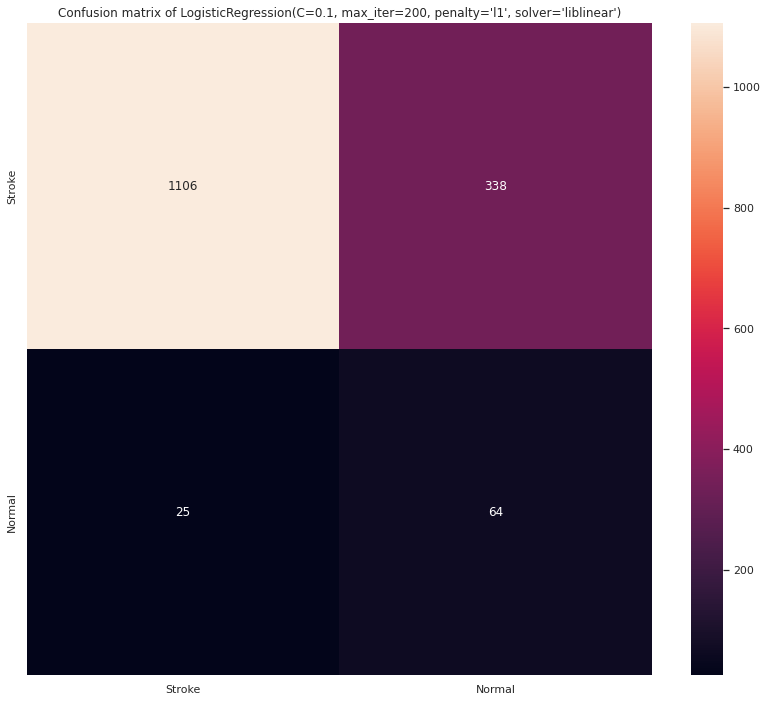

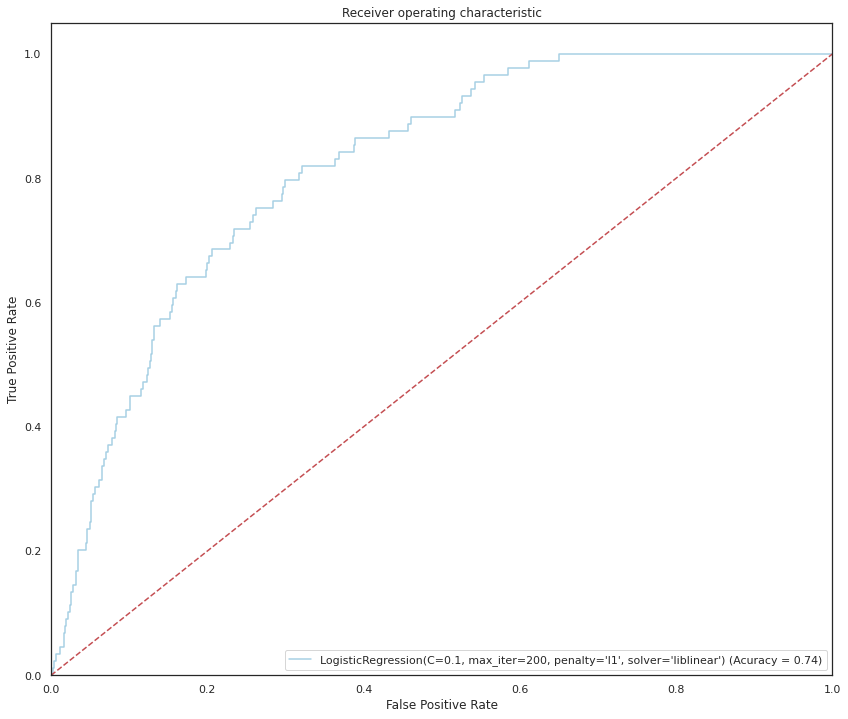

In [66]:
print("The Result of Logistic Regression is")
scores(my_logistic, x_test, y_test)
print()
roc(my_logistic, x_test, y_test)

## 2. Using **SVM model** to fit the training set 

In [36]:
def svm_model(X_train, y_train):
    svm = SVC()
    return svm

In [37]:
svm = svm_model(os_data_x,np.ravel(os_data_y,order='C')) 
# defining parameter range
params_grids_svm = {'C': [0.1,1, 10, 100], 
                    'gamma': [1,0.1,0.01,0.001],
                    'kernel': ['rbf','poly','sigmoid']}
randomsearch(svm, params_grids_svm, os_data_x, np.ravel(os_data_y,order='C'))

Best: 0.919646 using {'kernel': 'rbf', 'gamma': 1, 'C': 1}
0.426816 (0.011382) with: {'kernel': 'sigmoid', 'gamma': 1, 'C': 100}
0.833875 (0.012901) with: {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}
0.852316 (0.012384) with: {'kernel': 'poly', 'gamma': 0.1, 'C': 100}
0.541874 (0.035380) with: {'kernel': 'poly', 'gamma': 0.01, 'C': 0.1}
0.805916 (0.007001) with: {'kernel': 'sigmoid', 'gamma': 0.01, 'C': 10}
0.808551 (0.008398) with: {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
0.755856 (0.010341) with: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 0.1}
0.804598 (0.007801) with: {'kernel': 'poly', 'gamma': 0.1, 'C': 0.1}
0.919646 (0.011173) with: {'kernel': 'rbf', 'gamma': 1, 'C': 1}
0.805184 (0.008637) with: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 10}


In [69]:
my_svm = SVC(kernel='rbf', gamma=1, C=1,probability=True)
my_svm.fit(os_data_x, np.ravel(os_data_y,order='C'))

SVC(C=1, gamma=1, probability=True)

### Evaluation of SVM Model we built

The Result of SVM Model is

Acuracy     ========>>> 0.569


Precision ========>>> 0.117


Recall    ========>>> 0.258


F1        ========>>> 0.161





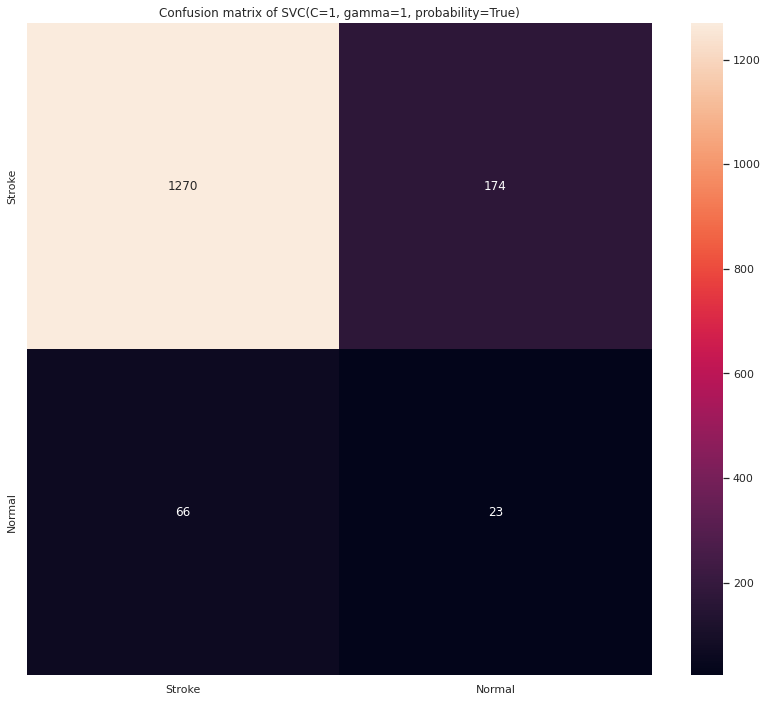

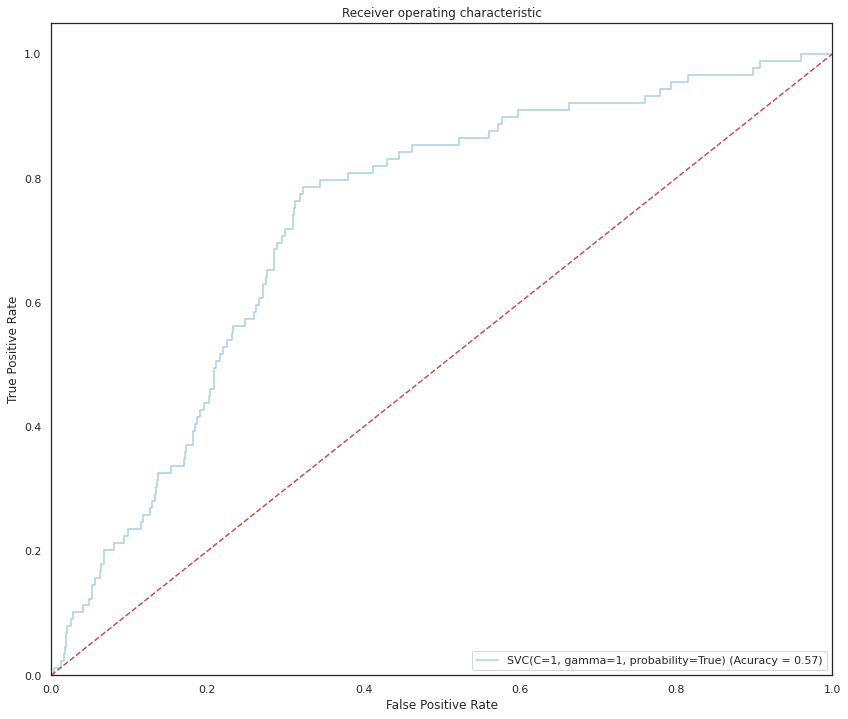

In [70]:
print("The Result of SVM Model is")
scores(my_svm, x_test, y_test)
print()
roc(my_svm, x_test, y_test)

## 3. Using **Decision Tree Model** to fit the training set 

In [40]:
def decision_tree(X_train, y_train):
    decision_tree_model = DecisionTreeClassifier()  
    return decision_tree_model

In [41]:
DecisionTree = decision_tree(os_data_x, np.ravel(os_data_y,order='C'))
# defining parameter range
params_grids_dt = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
      }
gridsearch(DecisionTree, params_grids_dt, os_data_x, np.ravel(os_data_y,order='C'))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best: 0.925361 using {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5}
0.901935 (0.011393) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
0.901935 (0.011393) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.901935 (0.011393) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}
0.901935 (0.011393) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 50}
0.901935 (0.011393) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 100}
0.799185 (0.023073) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
0.799185 (0.023073) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.799185 (0.023073) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}
0.793330 (0.023915) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50}
0.791573 (0.021328) with: {'criterion': 'gini', 'max_depth': 3

In [71]:
my_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5, random_state=42)
my_decision_tree.fit(os_data_x,np.ravel(os_data_y,order='C'))

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5,
                       random_state=42)

### Evaluation of Decision Tree Model we built

The Result of Decision Tree is

Acuracy     ========>>> 0.760


Precision ========>>> 0.141


Recall    ========>>> 0.831


F1        ========>>> 0.241





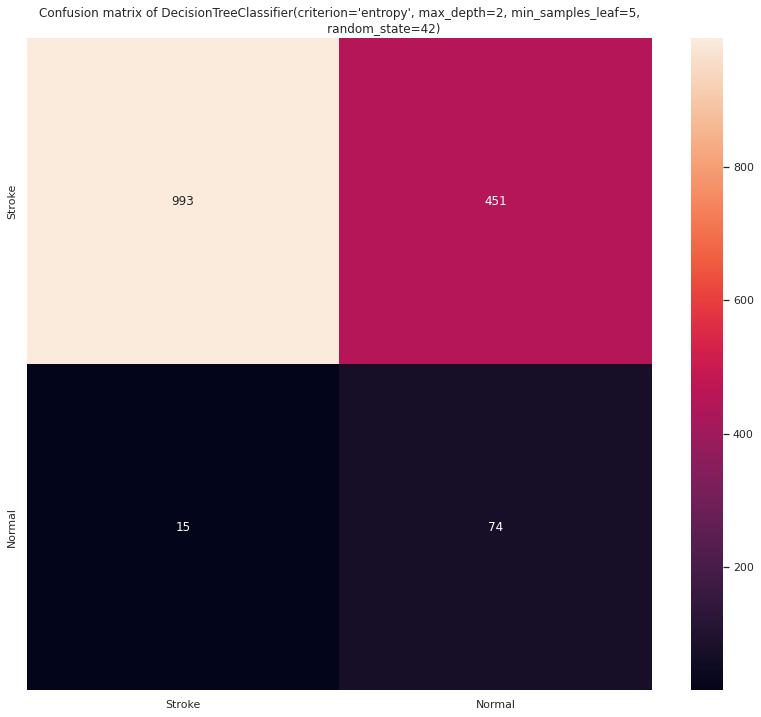

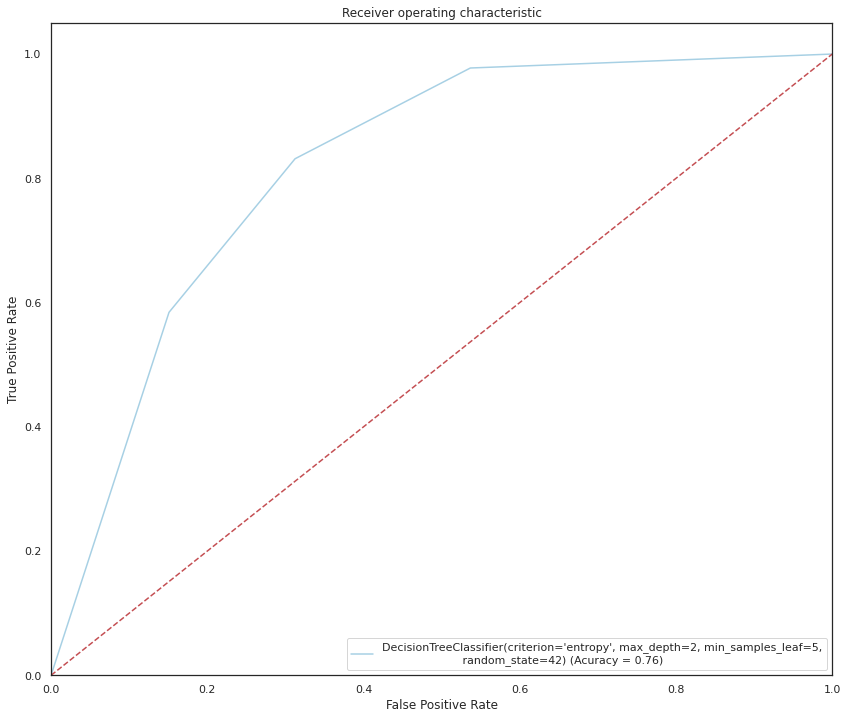

In [72]:
print("The Result of Decision Tree is")
scores(my_decision_tree, x_test, y_test)
print()
roc(my_decision_tree, x_test, y_test)

## 4. Using **Random Forest** to fit the training set 

In [44]:
def random_forest_model(X_train, y_train):
    random_forest_Model = RandomForestClassifier(random_state=26) # Please set the random state to be 26
    return random_forest_Model

In [45]:
random_forest = random_forest_model(os_data_x,np.ravel(os_data_y,order='C'))
params_grids_rf = {
    'max_depth': range(3,10,2),
    'max_features': range(3,9,2),
    'min_samples_leaf': range(10,60,10),
    'min_samples_split': range(50,201,20),
    'n_estimators': range(10,51,10)
      }
gridsearch(random_forest, params_grids_rf, os_data_x, np.ravel(os_data_y,order='C'))

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
Best: 0.917156 using {'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}
0.908086 (0.014425) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 10}
0.907208 (0.014463) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 20}
0.907795 (0.017221) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 30}
0.906622 (0.017015) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 40}
0.906328 (0.015651) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}
0.908086 (0.013946) with: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 70, 'n_estimators': 10}
0.907208 (0.014551) wi

In [73]:
my_rf_model = RandomForestClassifier(max_depth = 9 , max_features = 7 ,min_samples_leaf = 10 ,min_samples_split = 50 ,n_estimators = 50 ,random_state=26)
my_rf_model.fit(os_data_x, np.ravel(os_data_y,order='C')) 

RandomForestClassifier(max_depth=9, max_features=7, min_samples_leaf=10,
                       min_samples_split=50, n_estimators=50, random_state=26)

### Evaluation of Random Forest Model we built

The Result of Random Forest is

Acuracy     ========>>> 0.698


Precision ========>>> 0.167


Recall    ========>>> 0.573


F1        ========>>> 0.258





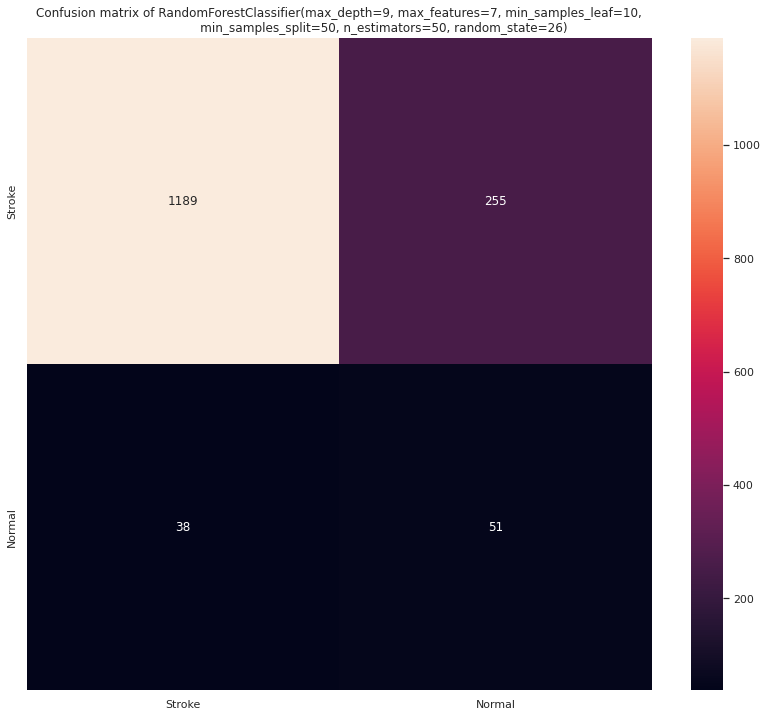

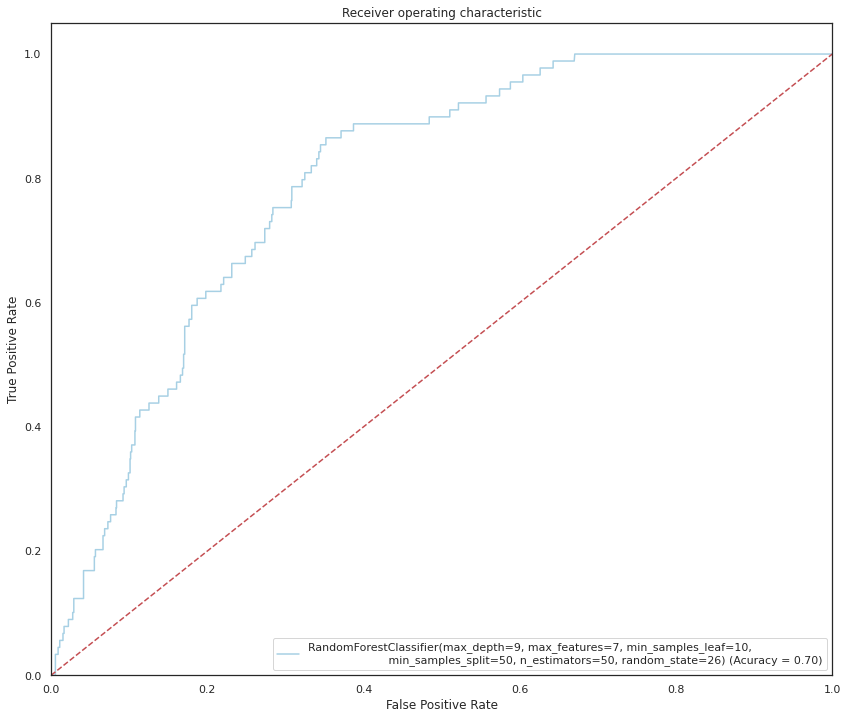

In [74]:
print("The Result of Random Forest is")
scores(my_rf_model, x_test, y_test)
print()
roc(my_rf_model, x_test, y_test)

## 5. Using **KNN Model** to fit the training set 

In [68]:
def knn_model(X_train, y_train):
    KNNModel = KNeighborsClassifier()
    return KNNModel

In [69]:
KNN = knn_model(os_data_x,np.ravel(os_data_y,order='C'))
metrics = ['euclidean','manhattan']
weight = ['uniform','distance']
neighbors = np.arange(1, 16)
p=[1,2]
#Convert to dictionary
params_grids_KNN = dict(metric=metrics, weights= weight, n_neighbors=neighbors, p=p)
gridsearch(KNN, params_grids_KNN, os_data_x, np.ravel(os_data_y,order='C'))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best: 0.988290 using {'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.940280 (0.013690) with: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.940280 (0.013690) with: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.978335 (0.009142) with: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.976285 (0.013144) with: {'metric': 'euclidean', 'n_n

In [75]:
my_knn_model = KNeighborsClassifier(n_neighbors = 12, weights = 'distance',p = 1, metric = 'manhattan')
my_knn_model.fit(os_data_x, np.ravel(os_data_y,order='C'))

KNeighborsClassifier(metric='manhattan', n_neighbors=12, p=1,
                     weights='distance')

### Evaluation of KNN Model we built

The Result of KNN Model is

Acuracy     ========>>> 0.668


Precision ========>>> 0.136


Recall    ========>>> 0.551


F1        ========>>> 0.218





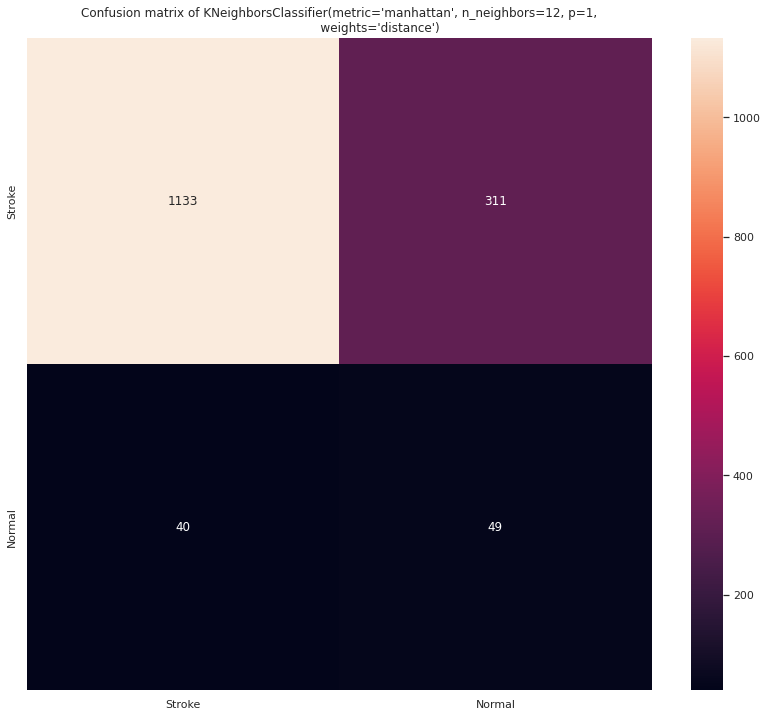

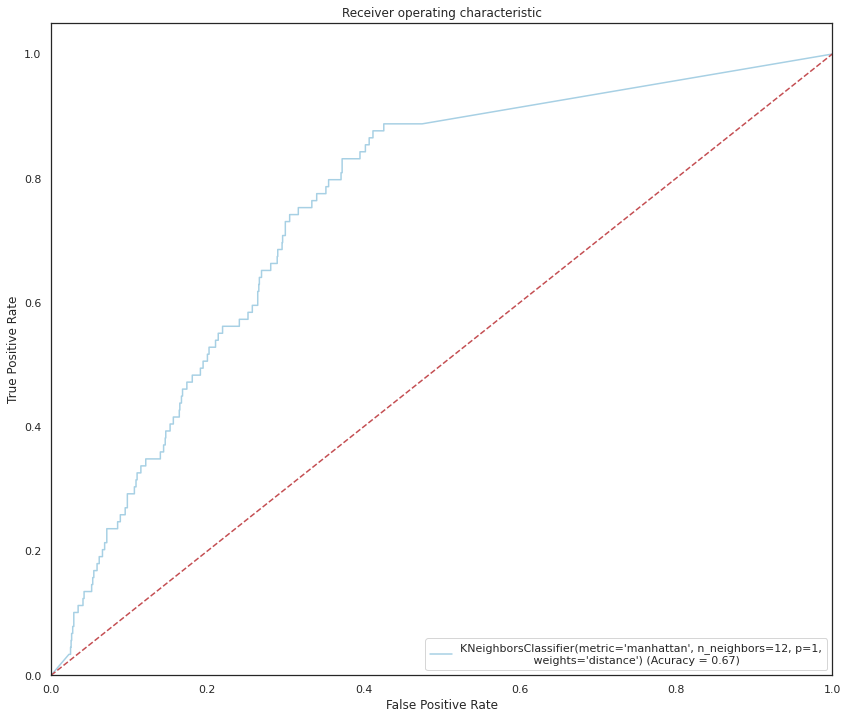

In [76]:
print("The Result of KNN Model is")
scores(my_knn_model, x_test, y_test)
print()
roc(my_knn_model, x_test, y_test)

## 6. Using **Neural Network Model** to fit the training set 

In [52]:
def build_clf():
      # creating the layers of the NN
      nn_model = Sequential()
      nn_model.add(Dense(25, input_dim= os_data_onehot.shape[1], activation='relu'))
      nn_model.add(Dropout(0.1))
      nn_model.add(Dense(25, activation='relu'))
      nn_model.add(Dropout(0.1))
      nn_model.add(Dense(25, activation='relu'))
      nn_model.add(Dropout(0.1))      
      nn_model.add(Dense(units=2, activation= 'softmax'))
      sgd = SGD(learning_rate=0.001, decay=1e-7, momentum=.9)  # Stochastic gradient descent
      nn_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 
      return nn_model

NN_model = KerasClassifier(model=build_clf, epochs=100, batch_size=32, verbose=0)

In [53]:
# define the grid search parameters
batch_sizes = [16, 32, 64]
epochs = [100, 200, 500]
optimizers=['RMSprop', 'Adam', 'Adamax', 'sgd']
param_grid_NN = dict(batch_size=batch_sizes, epochs=epochs, optimizer=optimizers)

randomsearch(NN_model, param_grid_NN, os_data_onehot, os_data_y)

Best: 0.900179 using {'optimizer': 'Adamax', 'epochs': 500, 'batch_size': 16}
0.900179 (0.010462) with: {'optimizer': 'Adamax', 'epochs': 500, 'batch_size': 16}
0.842071 (0.013160) with: {'optimizer': 'Adamax', 'epochs': 100, 'batch_size': 64}
0.892274 (0.008832) with: {'optimizer': 'Adamax', 'epochs': 200, 'batch_size': 16}
0.861537 (0.009410) with: {'optimizer': 'sgd', 'epochs': 200, 'batch_size': 64}
0.882176 (0.010236) with: {'optimizer': 'Adamax', 'epochs': 500, 'batch_size': 64}
0.898422 (0.009975) with: {'optimizer': 'sgd', 'epochs': 500, 'batch_size': 16}
0.882761 (0.012498) with: {'optimizer': 'Adam', 'epochs': 500, 'batch_size': 64}
0.892420 (0.006728) with: {'optimizer': 'Adam', 'epochs': 200, 'batch_size': 16}
0.871490 (0.010882) with: {'optimizer': 'Adamax', 'epochs': 100, 'batch_size': 16}
0.895350 (0.016817) with: {'optimizer': 'sgd', 'epochs': 500, 'batch_size': 32}


In [83]:
def random_NN_model():
      # creating the layers of the NN
      model = Sequential()
      model.add(Dense(25, input_dim = os_data_onehot.shape[1], activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(25, activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(25, activation='relu'))
      model.add(Dropout(0.1))      
      model.add(Dense(units=2, activation= 'softmax'))
      sgd = SGD(learning_rate=0.001, decay=1e-7, momentum=.9)  # Stochastic gradient descent
      model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=["accuracy"]) 
      return model

In [84]:
my_NN_model = random_NN_model()
my_NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                375       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

In [85]:
my_NN_model.fit(os_data_onehot, np.ravel(os_data_y,order='C'),epochs=500, batch_size=16, verbose= 0)

### Evaluation of Neural Network Model we built

The Result of Neural Network is

Acuracy     ========>>> 0.608


Precision ========>>> 0.128


Recall    ========>>> 0.371


F1        ========>>> 0.191





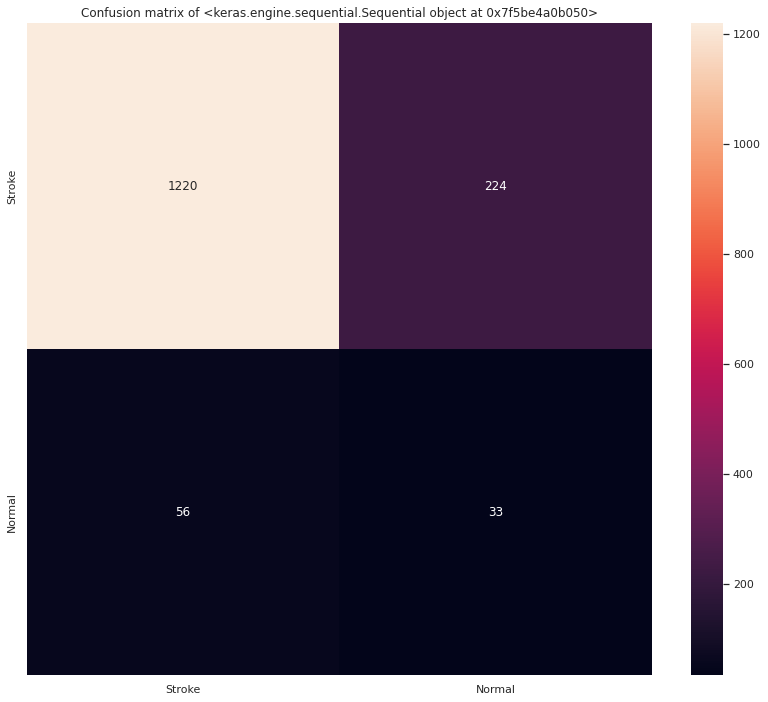

In [86]:
print("The Result of Neural Network is")
nnscores(my_NN_model, x_test_onehot, y_test)
print()

AUC of the dataset is 61.23%


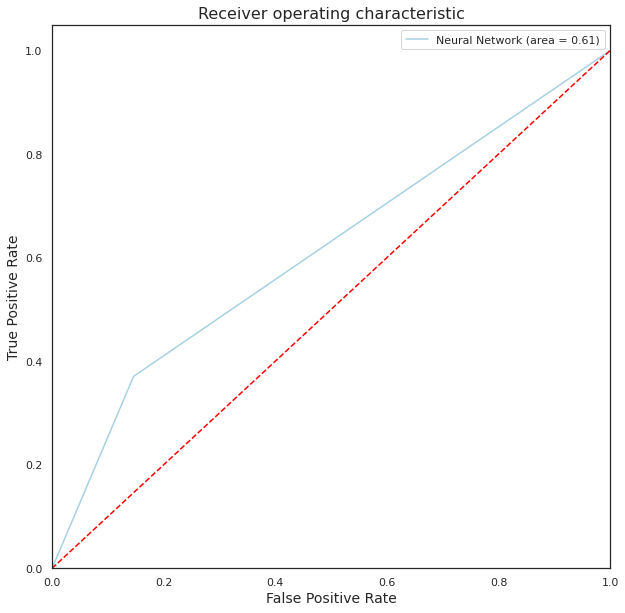

In [59]:
ypred = my_NN_model.predict(x_test_onehot)
ypred1 = np.argmax(ypred, axis = 1)
neural_auc_roc = roc_auc_score(y_test, ypred1)
fpr, tpr, thresholds = roc_curve(y_test, ypred1)
print(f'AUC of the dataset is {neural_auc_roc:.2%}')
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % neural_auc_roc)
plt.plot([0, 1], [0, 1],'r--', color = 'red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver operating characteristic', fontsize = 16)
plt.legend(loc="best")
plt.show()

## 7. Using **XGBoost Model** to fit the training set 

In [62]:
def xgb_model(X_train, y_train):
    XGBModel = xgb.XGBClassifier()
    return XGBModel

In [63]:
XGB = xgb_model(x_test_onehot, y_test)
parameters = {
        'max_depth': [3, 5, 7, 9], 
        'n_estimators': [5, 10, 15, 20, 25, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1]}
gridsearch(XGB, parameters, os_data_onehot, os_data_y)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.964575 using {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 100}
0.799185 (0.023073) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.799185 (0.023073) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
0.799185 (0.023073) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 15}
0.814119 (0.036057) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20}
0.818219 (0.031539) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 25}
0.862999 (0.016568) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.881740 (0.021118) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.891113 (0.027877) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.881452 (0.033640) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
0.884086 (0.033068) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 15}
0.883208 (0.033620) with: {'learning_rate': 0.01, 'max_dept

In [78]:
my_xgb_model = xgb.XGBClassifier(learning_rate = 0.05, max_depth =9, n_estimators=100)
my_xgb_model.fit(os_data_onehot, os_data_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(learning_rate=0.05, max_depth=9)

### Evaluation of XGBoost Model we built

The Result of XGBoost is

Acuracy     ========>>> 0.601


Precision ========>>> 0.155


Recall    ========>>> 0.303


F1        ========>>> 0.205





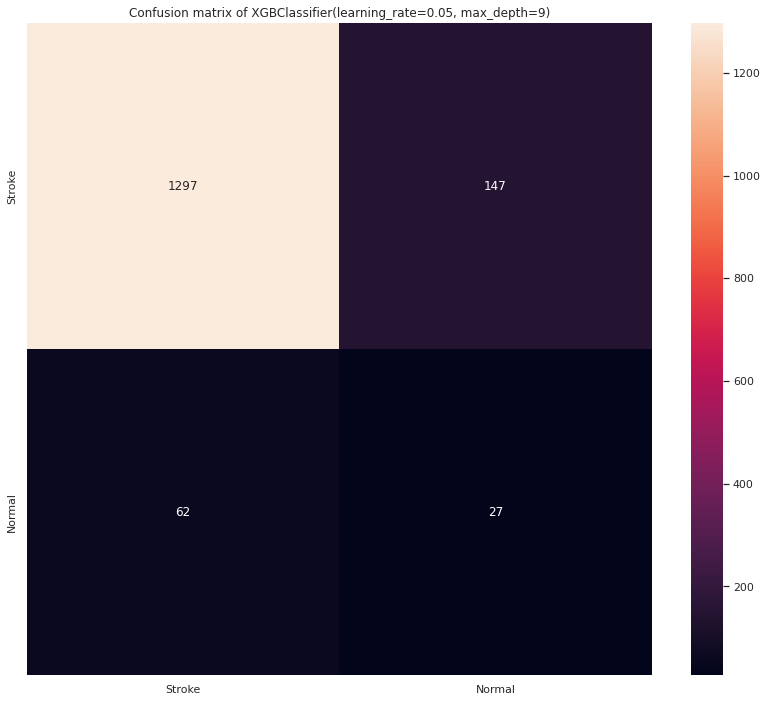

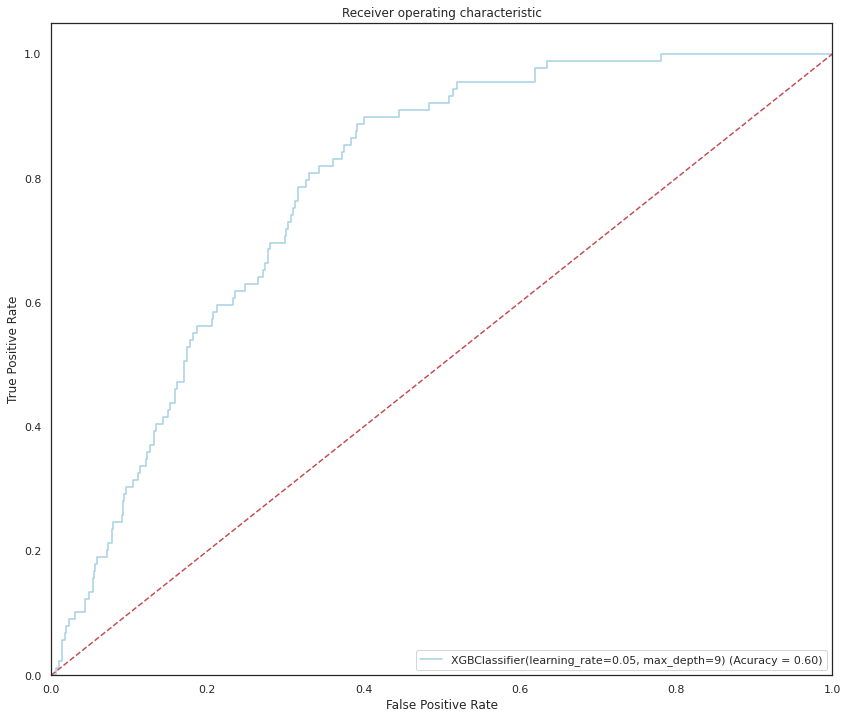

In [79]:
print("The Result of XGBoost is")
scores(my_xgb_model, x_test_onehot, y_test)
print()
roc(my_xgb_model, x_test_onehot, y_test)

# **Evaluating Model**

#### We need to focus on **Accuracy** and **Recall**. In this case, the cost of false negative is very high since if we don't fail to label a stroke patient, it will be extremely harmful. But if we label a non-patient as a patient, the cost is relatively low. We plot two barplot to compare **Accuracy** and **Recall** of each model.

In [87]:
my_model = (my_logistic, my_svm, my_decision_tree, my_rf_model, my_knn_model)
result_dict = {"Model Name":["Logistic", "SVM", "Decision Tree", "Random Forest", "KNN_Model"], "Auc":[],"Precision":[],"Recall":[],"F1":[]};
for models in my_model:
    model_auc = evaluation(models, x_test, y_test)[0]
    model_precision = evaluation(models, x_test, y_test)[1]
    model_recall = evaluation(models, x_test, y_test)[2]
    model_F1 = evaluation(models, x_test, y_test)[3]
    result_dict["Auc"].append(model_auc)
    result_dict["Precision"].append(model_precision)
    result_dict["Recall"].append(model_recall)
    result_dict["F1"].append(model_F1)
resultdf = pd.DataFrame(result_dict)
xgb_dict = {"Model Name":["XGBoost"], "Auc":[],"Precision":[],"Recall":[],"F1":[]}
nn_dict = {"Model Name":["Neural Network"], "Auc":[],"Precision":[],"Recall":[],"F1":[]}
xgbmodel_auc = evaluation(my_xgb_model, x_test_onehot, y_test)[0]
xgbmodel_precision = evaluation(my_xgb_model, x_test_onehot, y_test)[1]
xgbmodel_recall = evaluation(my_xgb_model, x_test_onehot, y_test)[2]
xgbmodel_F1 = evaluation(my_xgb_model, x_test_onehot, y_test)[3]
xgb_dict["Auc"].append(xgbmodel_auc)
xgb_dict["Precision"].append(xgbmodel_precision)
xgb_dict["Recall"].append(xgbmodel_recall)
xgb_dict["F1"].append(xgbmodel_F1)
xgbdf = pd.DataFrame(xgb_dict)
nnmodel_auc = nnevaluation(my_NN_model, x_test_onehot, y_test)[0]
nnmodel_precision = nnevaluation(my_NN_model, x_test_onehot, y_test)[1]
nnmodel_recall = nnevaluation(my_NN_model, x_test_onehot, y_test)[2]
nnmodel_F1 = nnevaluation(my_NN_model, x_test_onehot, y_test)[3]
nn_dict["Auc"].append(nnmodel_auc)
nn_dict["Precision"].append(nnmodel_precision)
nn_dict["Recall"].append(nnmodel_recall)
nn_dict["F1"].append(nnmodel_F1)
nndf = pd.DataFrame(nn_dict)
eva_result=pd.concat([resultdf,nndf,xgbdf], axis=0)
display(eva_result)

,Model Name,Auc,Precision,Recall,F1
0,Logistic,0.742515,0.159204,0.719101,0.260692
1,SVM,0.568964,0.116751,0.258427,0.160839
2,Decision Tree,0.759567,0.140952,0.831461,0.241042
3,Random Forest,0.698220,0.166667,0.573034,0.258228
4,KNN_Model,0.667594,0.136111,0.550562,0.218263
0,Neural Network,0.607831,0.128405,0.370787,0.190751
0,XGBoost,0.600785,0.155172,0.303371,0.205323


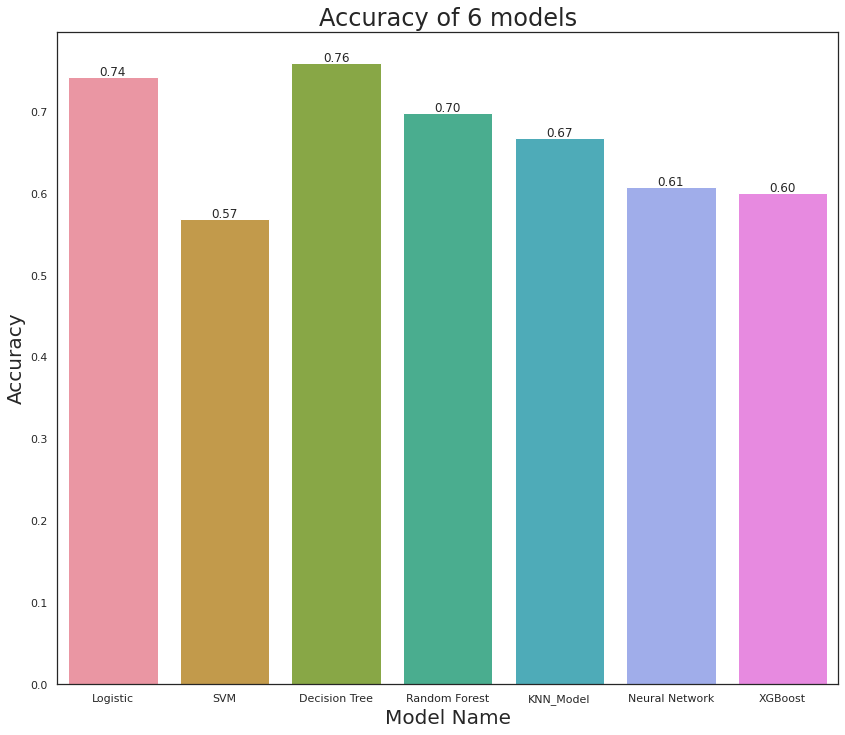

In [88]:
g5 = sns.barplot(x="Model Name", y='Auc', data= eva_result)
g5.set_title("Accuracy of 6 models",fontdict= { 'fontsize': 24})
g5.set_xlabel("Model Name",fontsize = 20)
g5.set_ylabel("Accuracy",fontsize = 20)
for p in g5.patches:
    g5.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0,5), 
                   textcoords = 'offset points')
plt.show()

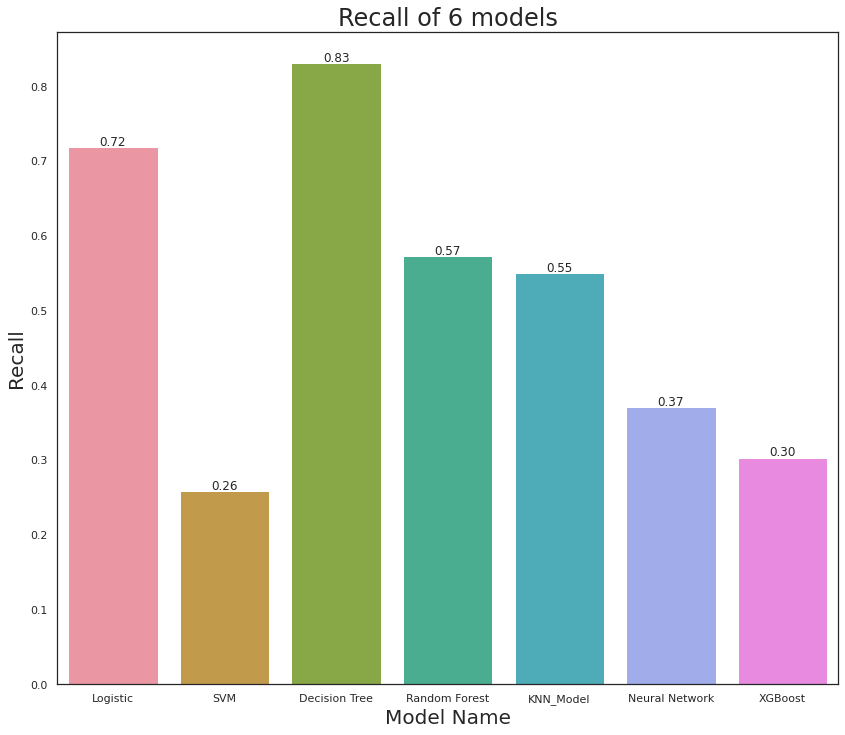

In [89]:
g6 = sns.barplot(x="Model Name", y='Recall', data= eva_result)
g6.set_title("Recall of 6 models",fontdict= {'fontsize': 24})
g6.set_xlabel("Model Name",fontsize = 20)
g6.set_ylabel("Recall",fontsize = 20)
for p in g6.patches:
    g6.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0,5), 
                   textcoords = 'offset points')
plt.show()

### As We can clearly see, **Decision Tree** has the best Accuracy and Recall, which make it the best model in our case. There is one thing needed to be noticed: The precisions of all models are very bad, which could due to the small size of the sample.